# Trabalho de IA: MLP

- Fazer leitura dos dados testes
- Fazer o loop das épocas
- Conferir o backpropagation
- Testar com conj binários

Depois:
Otimização e análise
- Parada antecipada
- Rever o doc de especificação do trabalho para montar os gráficos
- Começar a guardar os pesos (e perguntar pra prof o porquê)

##Preparando o ambiente

In [217]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from graphviz import Digraph
import json


In [218]:
alfabeto = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Função que transforma letra em vetor
def letra_para_vetor(letra):
    vetor = [0] * 26
    pos_letra = alfabeto.index(letra)
    vetor[pos_letra] = 1

    return vetor

# Função que transforma vetor em letra
def vetor_para_letra(vetor):
    # Encontra a posição do maior valor no vetor
    maior_pos = np.argmax(vetor)

    # Encontra a letra correspondente no alfabeto
    letra = alfabeto[maior_pos]

    return letra

In [219]:
def ler_arq_imagens(nome_arq):
    """
    Lê o arquivo de imagens e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de imagens.

    Returns:
        np.ndarray: Array numpy contendo as imagens.
    """
    with open(nome_arq, 'r') as file:
        data = file.read().strip().split('\n')
    data = [list(map(int, filter(lambda x: x.strip(), line.split(',')))) for line in data if line.strip()]
    return np.array(data)

def ler_arq_classes(nome_arq):
    """
    Lê o arquivo de classes e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de classes.

    Returns:
        np.ndarray: Array numpy contendo as classes.
    """
    with open(nome_arq, 'r') as file:
        data = file.read().strip().split('\n')
    return np.array(data)

In [207]:
def encode_labels(labels):
    """
    Codifica as classes em valores numéricos únicos.

    Args:
        labels (np.ndarray): Array de classes textuais.

    Returns:
        np.ndarray: Array de classes codificadas numericamente.
        dict: Dicionário de mapeamento de classe para valor numérico.
    """
    unique_labels = np.unique(labels)
    label_to_num = {label: num for num, label in enumerate(unique_labels)}
    encoded_labels = np.array([label_to_num[label] for label in labels])
    return encoded_labels, label_to_num


Funcao pra reconstruir imagens a partir do array de array


In [208]:
def reconstruct_image(row_index, image_array):
    """
    Reconstrói e plota uma imagem a partir do array numpy.

    Args:
        row_index (int): Índice da linha da imagem a ser reconstruída.
        image_array (np.ndarray): Array numpy contendo as imagens.
    """
    image_array = image_array[row_index]
    image_reshaped = np.reshape(image_array, (10, 12))

    plt.figure(figsize=(4, 3))
    plt.imshow(image_reshaped, cmap='gray')
    plt.colorbar()
    plt.show()

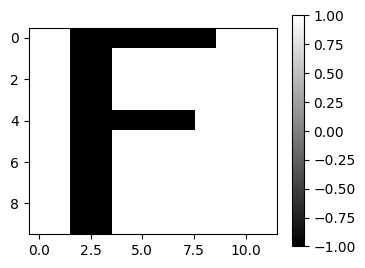

In [209]:
image = ler_arq_imagens('X.txt')
reconstruct_image(5,image)

In [210]:
def activation(x):
    return np.tanh(x)

In [211]:
def derivative_activation(x):
    return 1 - np.tanh(x) ** 2

In [212]:

class Layer:
    def __init__(self, input_size, output_size, learning_rate):
        """
        Inicializa uma nova camada na rede neural.

        Args:
            input_size (int): Número de neurônios na camada anterior ou tamanho dos dados de entrada.
            output_size (int): Número de neurônios na camada atual.
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.

        Attributes:
            weights (np.array): Matriz de pesos, onde cada peso conecta um neurônio de entrada a um neurônio de saída.
            biases (np.array): Vetor de biases, um para cada neurônio de saída.
            weighted_input (np.array): Armazena a entrada ponderada (antes da aplicação de qualquer função de ativação).
            output_data (np.array): Armazena a saída da camada, que neste caso é simplesmente a entrada ponderada.
            input_data (np.array): Armazena a entrada da camada antes da ponderação.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.random.randn(1, output_size) * 0.01  # Corrigido para ter a forma (1, output_size)
        self.learning_rate = learning_rate
        self.weighted_input = None
        self.output_data = None
        self.input_data = None

    def forward(self, input_data):
        self.input_data = input_data
        self.weighted_input = np.dot(input_data, self.weights) + self.biases
        self.output_data = activation(self.weighted_input)
        return self.output_data

    def backward(self, output_error):
        error = output_error * derivative_activation(self.weighted_input)
        if self.input_data.ndim == 1:
            self.input_data = self.input_data.reshape(-1, 1)  # Convertendo para vetor coluna
        if error.ndim == 1:
            error = error.reshape(1, -1)  # Garantindo que error é bidimensional

        input_error = np.dot(error, self.weights.T)
        weights_error = np.dot(self.input_data, error)

        # Atualiza pesos e biases
        self.weights -= self.learning_rate * weights_error
        self.biases -= self.learning_rate * np.sum(error, axis=0, keepdims=True)
        return input_error
    
    

In [213]:
class NeuralNetwork:
    def __init__(self, learning_rate=0.01):
        """
        Inicializa a rede neural com camadas especificadas.

        Args:
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.

        Attributes:
            learning_rate (float): Taxa de aprendizado da rede neural.
            input_layer (Layer): Camada de entrada da rede neural.
            hidden_layer1 (Layer): Primeira camada oculta da rede neural.
            hidden_layer2 (Layer): Segunda camada oculta da rede neural.
            output_layer (Layer): Camada de saída da rede neural.
            final_output (np.array): Armazena a saída final da rede após a propagação direta.
        """
        self.learning_rate = learning_rate
        self.input_layer = Layer(120, 100, self.learning_rate)
        self.hidden_layer1 = Layer(100, 60, self.learning_rate)
        self.hidden_layer2 = Layer(60, 30, self.learning_rate)
        self.output_layer = Layer(30, 26, self.learning_rate)
        self.final_output = None
        
    def forward_propagation(self,input_data):
        """
        Realiza a propagação para frente através de toda a rede.
        
        Args:
            input_data (np.array): Dados de entrada para a rede.
        
        Returns:
            np.array: Saída final da rede.
        """
        output = self.input_layer.forward(input_data)
        output = self.hidden_layer1.forward(output)
        output = self.hidden_layer2.forward(output)
        self.final_output = self.output_layer.forward(output)
        return self.final_output

    def back_propagation(self, output_error):
        """
        Realiza a propagação para trás através de toda a rede.
        
        Args:
            output_error (np.array): Erro na saída da rede.
        """
        error = self.output_layer.backward(output_error)
        error = self.hidden_layer2.backward(error)
        error = self.hidden_layer1.backward(error)
        self.input_layer.backward(error)

    #Função para salvar os pesos da rede neural em um arquivo 
    def save_weights(self, file_name):
        #Criando um dicionário para salvar os pesos de todas as camadas
        weights = {
            #Conversão dos pesos da camada de entrada para uma lista
            'input_layer': self.input_layer.weights.tolist(), 
            #Conversão dos pesos da primeira camada oculta para uma lista
            'hidden_layer1': self.hidden_layer1.weights.tolist(),
            #Conversão dos pesos da segunda camada oculta para uma lista
            'hidden_layer2': self.hidden_layer2.weights.tolist(),
            #Conversão dos pesos da camada de saída para uma lista
            'output_layer': self.output_layer.weights.tolist(),
        }
        #Abertura do arquivo para escrita
        with open(file_name, 'w') as f:
            #Salvando o dicionário no fomrato JSON
            json.dump(weights, f)
            
            

In [214]:
class MultilayerPerceptron:
    def __init__(self, min_output_error=0.001, max_epochs_num=10000, early_stop_param=10):
        """
        Inicializa os parâmetros para o treinamento da rede neural.

        Args:
            min_output_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            early_stop_param (int): Número de épocas consecutivas com aumento do erro permitido antes da parada antecipada.

        Attributes:
            min_output_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            early_stop_param (int): Número de épocas consecutivas com aumento do erro permitido antes da parada antecipada.
            negative_error_var_num (int): Contador de épocas com aumento do erro.
            current_epoch_error (float): Taxa de erro da época atual.
            last_epoch_error (float): Taxa de erro da última época.
        """
        self.min_output_error = min_output_error
        self.max_epochs_num = max_epochs_num
        self.early_stop_param = early_stop_param
        self.negative_error_var_num = 0
        self.current_epoch_error = 0
        self.last_epoch_error = 0
        #Lista para armazenar os erros de treinamento em cada época
        self.training_errors = [] 


    def train(self, X_train, y_train, neural_network):
            """
            Treina a rede neural usando o conjunto de dados de treinamento.
            
            Args:
                X_train (np.array): Dados de entrada para treinamento.
                y_train (np.array): Labels correspondentes para o treinamento.
                neural_network (NeuralNetwork): Instância da rede neural a ser treinada.
            """
            for epoch in range(self.max_epochs_num):
                epoch_error = 0
                for x, y in zip(X_train, y_train):
                    output = neural_network.forward_propagation(x)
                    output_error = y - output
                    neural_network.back_propagation(output_error)
                    epoch_error += np.mean(np.abs(output_error))
                
                self.training_errors.append(epoch_error)
                print(f"Epoch {epoch+1}/{self.max_epochs_num}, Error: {epoch_error}")

                # Early stopping criteria
                if epoch_error < self.min_output_error:
                    print("Erro mínimo atingido. Parando o treinamento.")
                    break
                
                if epoch > 0 and self.training_errors[epoch] > self.training_errors[epoch - 1]:
                    self.negative_error_var_num += 1
                else:
                    self.negative_error_var_num = 0

                if self.negative_error_var_num >= self.early_stop_param:
                    print("Parando antecipadamente devido ao aumento contínuo do erro.")
                    break

    def predict(self, X_test, neural_network):
        """
        Realiza predições usando a rede neural treinada.
        
        Args:
            X_test (np.array): Dados de entrada para teste.
            neural_network (NeuralNetwork): Instância da rede neural treinada.
        
        Returns:
            np.array: Predições da rede neural.
        """
        predictions = []
        for x in X_test:
            output = neural_network.forward(x)
            predictions.append(output)
        return np.array(predictions)
    

In [215]:
def dividir_dados(X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(len(indices) * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


In [220]:
def main():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')
    
    # Dividindo os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = dividir_dados(imagens, classes, test_size=0.2)
    
    # Codificando as classes manualmente
    y_train, label_to_num = encode_labels(y_train)
    y_test, _ = encode_labels(y_test)

    # Convertendo para float
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)
    
    # Inicializa a rede neural
    neural_network = NeuralNetwork(learning_rate=0.01)

    # Parâmetros para o treinamento
    min_output_error = 0.001
    max_epochs_num = 10000
    early_stop_param = 10

    # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
    mlp = MultilayerPerceptron(min_output_error, max_epochs_num, early_stop_param)

    # Treina a rede neural
    mlp.train(X_train, y_train, neural_network)

    # Testa a rede neural
    predictions = mlp.predict(X_test, neural_network)

    # Exibe algumas predições para verificação
    for i in range(10):
        print(f"Predição: {predictions[i]}, Real: {y_test[i]}")

if __name__ == "__main__":
    main()

ValueError: shapes (120,) and (1,100) not aligned: 120 (dim 0) != 1 (dim 0)

In [ ]:
from sklearn.model_selection import KFold

#Função para treinar a camada da arede neural
def train(layer, X_train, y_train, epochs):
    for epoch in range(epochs):
        for x, y in zip(X_train, y_train):
            layer.train(x, y)

#Função para valiar a camada da rede nneural nos dados de teste
def evaluate(layer, X_test, y_test):
    correct_predictions = 0
    for x, y_true in zip(X_test, y_test):
        y_pred = layer.forward_layers(x)
        if np.argmax(y_pred) == np.argmax(y_true):
            correct_predictions += 1
    accuracy = correct_predictions / len(X_test)
    return accuracy

#Função do Cross-validation
def cross_validation(layer_class, X, y, k=5, epochs=100, learning_rate=0.01):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Cria uma nova instância da camada para cada fold
        input_size = X.shape[1]
        output_size = y.shape[1]
        layer = layer_class(input_size, output_size, learning_rate)

        # Treina a camada
        train(layer, X_train, y_train, epochs)

        # Avalia a camada
        accuracy = evaluate(layer, X_test, y_test)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    return mean_accuracy


Exemplo de uso:

In [ ]:
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')
print(imagens.head())


   0    1    2    3    4    5    6    7    8    9    ...  110  111  112  113  \
0    1    1    1    1   -1   -1    1    1    1    1  ...    1    1    1    1   
1    1    1   -1   -1   -1   -1   -1   -1    1    1  ...   -1   -1   -1   -1   
2    1    1    1    1   -1   -1   -1   -1   -1    1  ...    1    1   -1   -1   
3    1    1   -1   -1   -1   -1   -1   -1    1    1  ...   -1   -1   -1   -1   
4    1    1   -1   -1   -1   -1   -1   -1   -1    1  ...   -1   -1   -1   -1   

   114  115  116  117  118  119  
0    1    1   -1    1    1    1  
1   -1   -1    1    1    1    1  
2   -1   -1   -1    1    1    1  
3   -1   -1    1    1    1    1  
4   -1   -1   -1   -1    1    1  

[5 rows x 120 columns]


In [ ]:
print(classes.head())

  letra
0     A
1     B
2     C
3     D
4     E


In [ ]:
# Executando o treinamento e teste da rede neural
mlp = MultilayerPerceptron()
mlp.main(imagens, classes)#

AttributeError: 'MultilayerPerceptron' object has no attribute 'main'

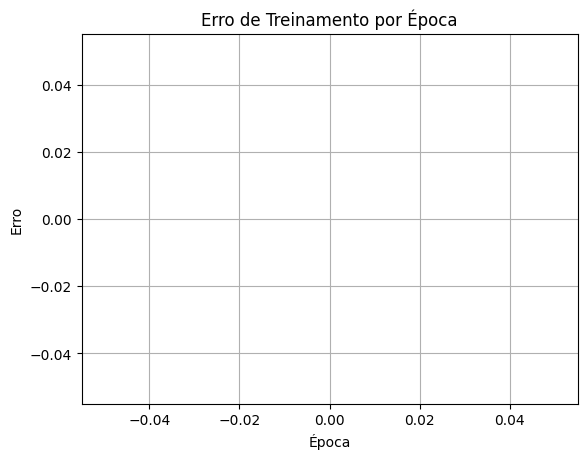

In [ ]:
# Plotando o erro de treinamento
plt.plot(mlp.training_errors)
plt.title('Erro de Treinamento por Época')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.grid(True)
plt.show()


In [ ]:
# Criação de uma tabela com os erros de treinamento
df_erros_treinamento = pd.DataFrame({
    'Época': range(len(mlp.training_errors)),
    'Erro': mlp.training_errors
})

# Exibindo a tabela
print(df_erros_treinamento)


Empty DataFrame
Columns: [Época, Erro]
Index: []


Falta:

- cross-validation
- 

# Roteiro para vídeo

V1:
- Parte de treinamento do código (com e sem validação cruzada e parada antecipada) PARA: conjunto de dados CARACTERES COMPLETO (os outros de teste não entram)
- Estudo dos parâmetros (busca por valores adequados – grid) (?)
- Teste da MLP para o conjunto de dados CARACTERES COMPLETO

V2:
- 
